In [2]:
import pandas as pd
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
import re
import seaborn

In [5]:
### CONFIGURATION
#
# number of folds
n_folds = 10
#
# run entity identification task or entity classification task
just_identify = False
#
# plot the confusion matrices?
should_plot_matrices = True
###

## Separate TRAIN and TEST folds for the NER task

In [14]:
kf = KFold(n_splits=n_folds)
current_fold = 0

df = pd.read_csv("../Dataset/dataset_processed.csv")

for train_docs_indexes, test_docs_indexes in kf.split(df["doc_index"].unique()):
    train_docs = []
    test_docs = []
    
    for doc_index in train_docs_indexes:
        doc = df.loc[df['doc_index'] == doc_index]
        train_docs.append(doc)
    train = pd.concat(train_docs, ignore_index=True)
    train.to_csv("folds/train_fold_" + str(current_fold) + ".csv")
    
    for doc_index in test_docs_indexes:
        doc = df.loc[df['doc_index'] == doc_index]
        test_docs.append(doc)
    test = pd.concat(test_docs, ignore_index=True)
    test.to_csv("folds/test_fold_" + str(current_fold) + ".csv")
    
    current_fold += 1

DONE


## Load Dataframe from CSV and transform to CoNLL format

In [15]:
def write_sentence_to_file(text, file):
    words_list = text.split()
    for word in words_list:
        file.write(word + " O" + "\n")    

In [16]:
def write_entity_to_file(entity, tipo, file, just_identify=False):
    words_list = entity.split()
    for index, word in enumerate(words_list):
        if (index == 0):
            if (just_identify):
                file.write(word + " B" + "\n")
            else:
                file.write(word + " B-" + tipo + "\n")
        else:
            if (just_identify):
                file.write(word + " I" + "\n")
            else:
                file.write(word + " I-" + tipo + "\n")

In [17]:
def create_conll_file(input_path, output_path):
    df = pd.read_csv(input_path)
    
    p_indexes_set = set(df["p_index"])
    
    # Force utf-8 encoding because SimpleTransformers use this encoding
    with open(output_path, "w+", encoding="utf-8") as fileWriter:
        for p_index in p_indexes_set:
            sentence = df.loc[df.p_index == p_index, "p_sentence_processed"].values[0]
            entities = df.loc[df.p_index == p_index, "entity"].values
            tipos = df.loc[df.p_index == p_index, "tipo_final"].values

            for entity_index, entity in enumerate(entities):
                entity_start_index = sentence.index(entity)
                entity_end_index = entity_start_index + len(entity)

                sentence_before = sentence[:entity_start_index]
                # Write in the file only the words that are not entities and appeared before the current entity
                write_sentence_to_file(sentence_before, fileWriter)

                tipo = tipos[entity_index]
                # Write in the file only the words that make up the current entity
                write_entity_to_file(entity, tipo, fileWriter, just_identify)

                # Remove the excerpt that has already been processed from the sentence
                sentence = sentence[entity_end_index:]

            # Write in the file the words that remain in the sentence (not entities)
            write_sentence_to_file(sentence, fileWriter)

            fileWriter.write("\n")

In [18]:
if (just_identify):
    dst_folder = "folds_CoNLL_identification/"
else:
    dst_folder = "folds_CoNLL_classification/"

for i in range(n_folds):
    test_input = "folds/test_fold_{}.csv".format(i)
    test_output = dst_folder + "CoNLL_test_fold_{}.txt".format(i)
    
    create_conll_file(test_input, test_output)
    
    train_input = "folds/train_fold_{}.csv".format(i)
    train_output = dst_folder + "CoNLL_train_fold_{}.txt".format(i)
    
    create_conll_file(train_input, train_output)

## Fix sentence size in CoNLL
SimpleTransformers only accepts sentences of up to 512 words.
If the sentence starts to get too long (>300), break it at the next "period".

In [19]:
def fix_sentences_size_in_conll(input_path, output_path):
    with open(input_path, "r", encoding="utf-8") as fileReader:
        with open(output_path, "+w", encoding="utf-8") as fileWriter:
            counter_words_in_sentence = 0
            for linha in fileReader:
                counter_words_in_sentence += 1
                if (counter_words_in_sentence > 300 and '. O' in linha):
                    # the sentence is getting too long, you better break it
                    fileWriter.write(linha)
                    fileWriter.write("\n")
                    counter_words_in_sentence = 0
                else:
                    if (linha):
                        # replicates the sentence line normally
                        fileWriter.write(linha)
                    else:
                        # if the sentence is over, you have to reset the counter
                        fileWriter.write("\n")
                        counter_words_in_sentence = 0

In [22]:
if (just_identify):
    dst_folder = "folds_CoNLL_identification/"
else:
    dst_folder = "folds_CoNLL_classification/"
    
for i in range(n_folds):
    train_path = dst_folder + "CoNLL_train_fold_{}.txt".format(i)
    train_path_v2 = dst_folder + "CoNLL_train_fold_{}_v2.txt".format(i)
    
    fix_sentences_size_in_conll(train_path, train_path_v2)
    
    test_path = dst_folder + "CoNLL_test_fold_{}.txt".format(i)
    test_path_v2 = dst_folder + "CoNLL_test_fold_{}_v2.txt".format(i)
    
    fix_sentences_size_in_conll(test_path, test_path_v2)

## EXTRA STEP:
The next step will be done in the Google Colab environment.

Save CoNLLv2 files to Google Drive and run colab_SimpleTransformers from Colab.

Take the files with the predictions and save them in the same folder as the CoNLLv2 files.

After saving all the files, you can proceed to the next step.

## Create confusion matrix for each fold

----- FOLD 0 -----
9027
9027
precision_micro = 0.9819430597097596
precision_macro = 0.9548857261867889
recall_micro = 0.9819430597097596
recall_macro = 0.949289725171505
f1_micro = 0.9819430597097596
f1_macro = 0.9520519880940611


----- FOLD 1 -----
10439
10439
precision_micro = 0.97269853434237
precision_macro = 0.9511983472277764
recall_micro = 0.97269853434237
recall_macro = 0.9513999654970348
f1_micro = 0.97269853434237
f1_macro = 0.951292764688624


----- FOLD 2 -----
8695
8695
precision_micro = 0.9813686026451984
precision_macro = 0.9554925258475606
recall_micro = 0.9813686026451984
recall_macro = 0.9674375455016339
f1_micro = 0.9813686026451984
f1_macro = 0.9612038512806929


----- FOLD 3 -----
3415
3415
precision_micro = 0.9689604685212299
precision_macro = 0.9482511610724034
recall_micro = 0.9689604685212299
recall_macro = 0.9414201525672686
f1_micro = 0.9689604685212299
f1_macro = 0.9447995776320973


----- FOLD 4 -----
3350
3350
precision_micro = 0.9850746268656716
precisio

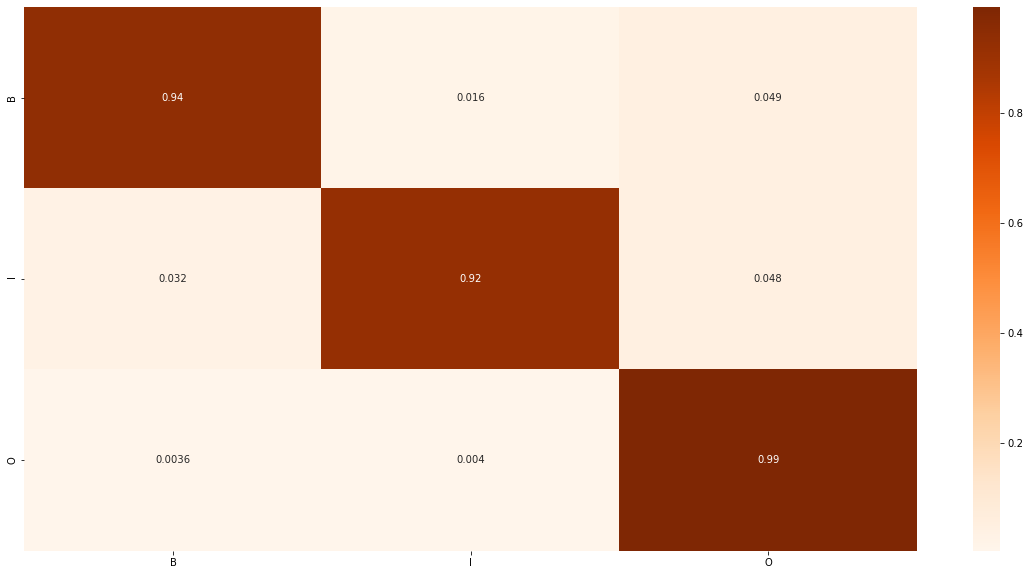

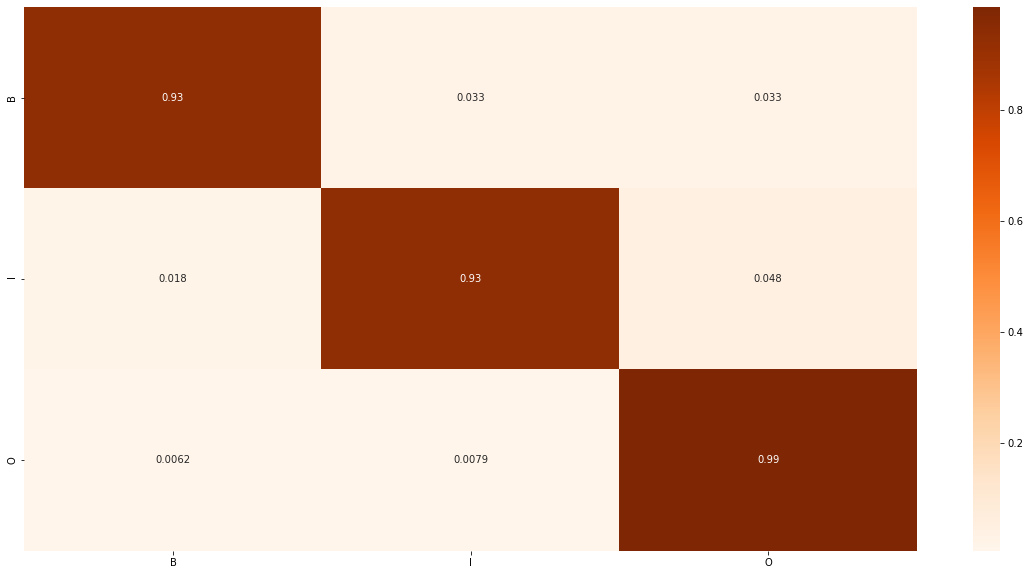

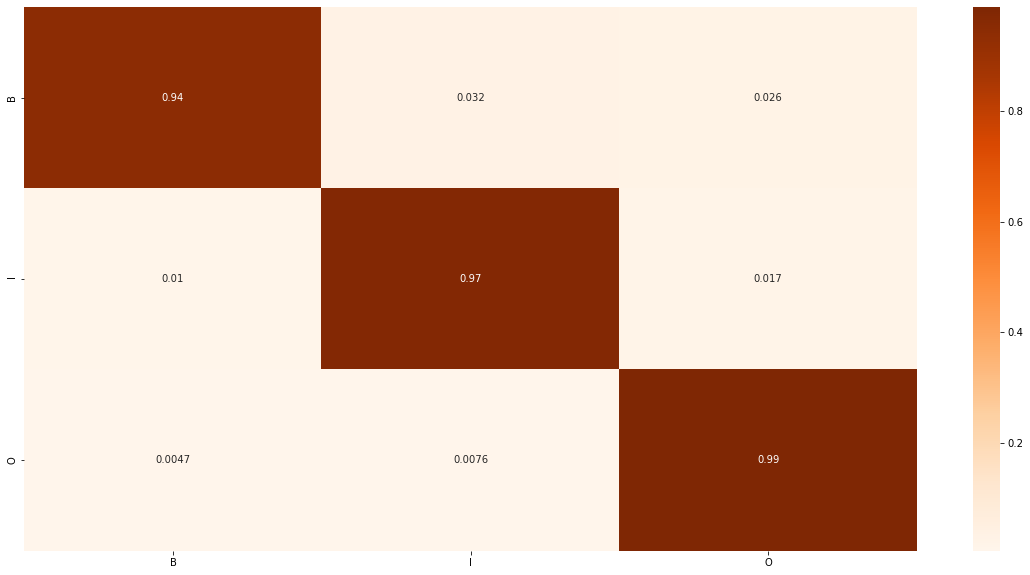

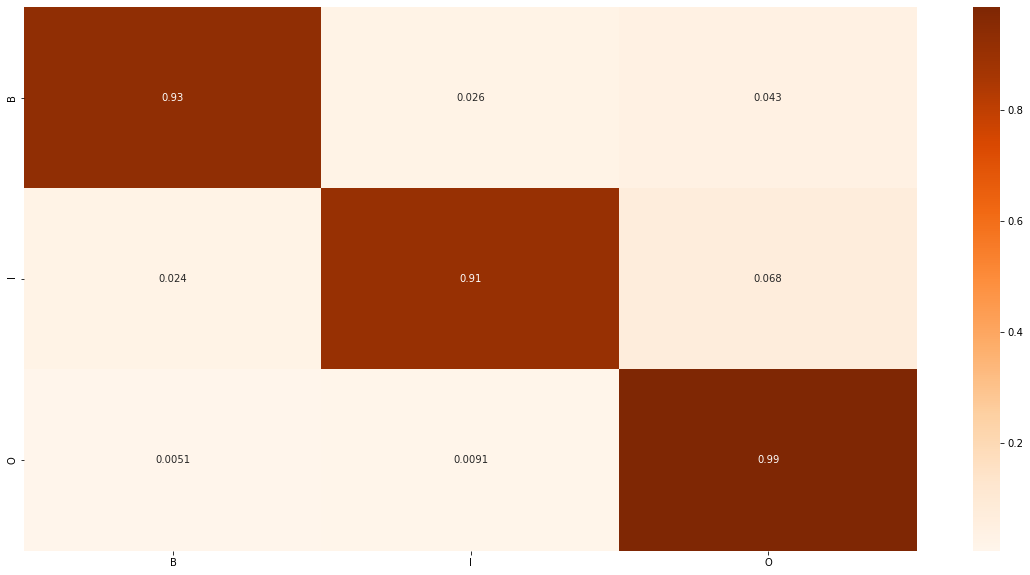

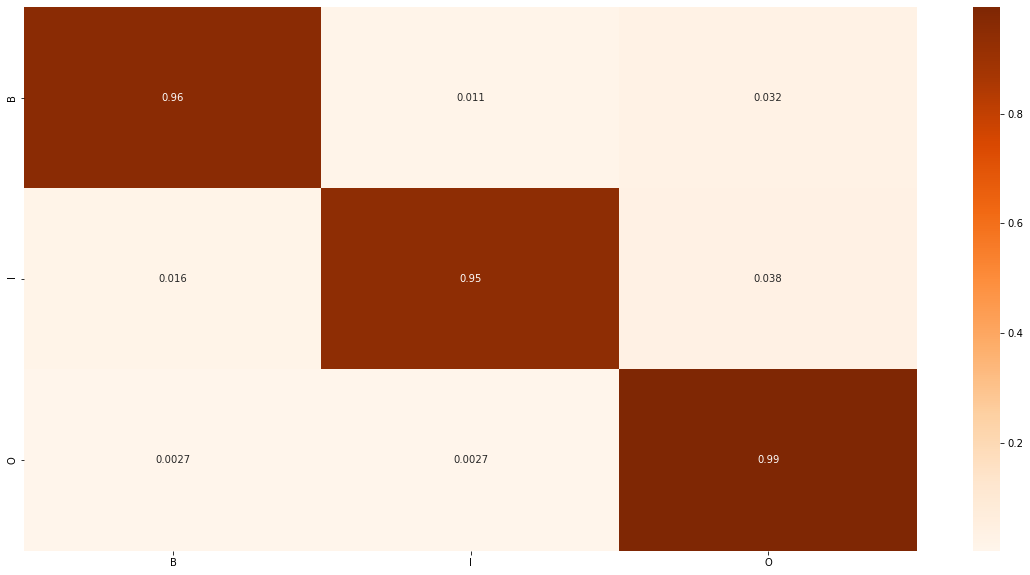

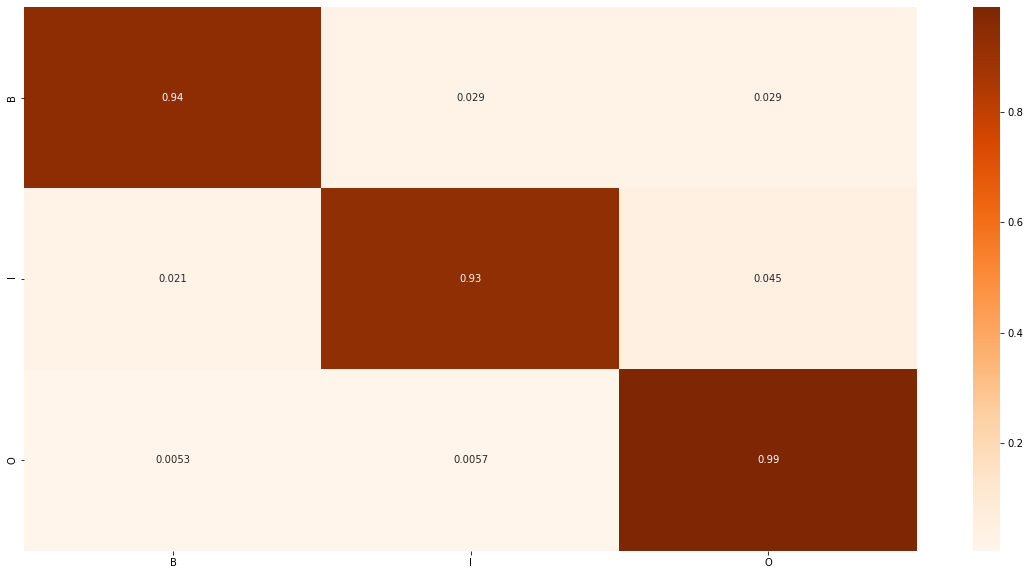

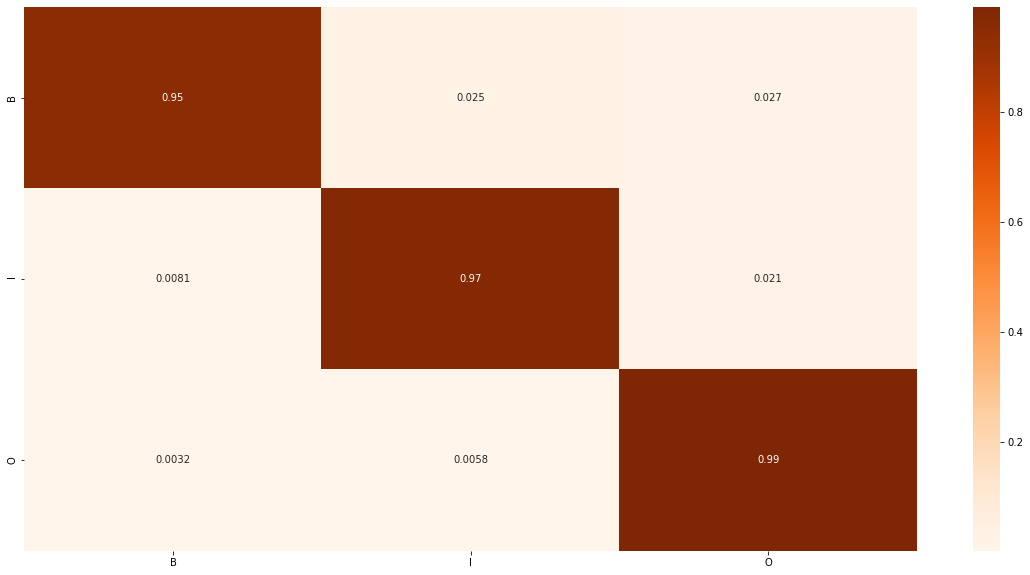

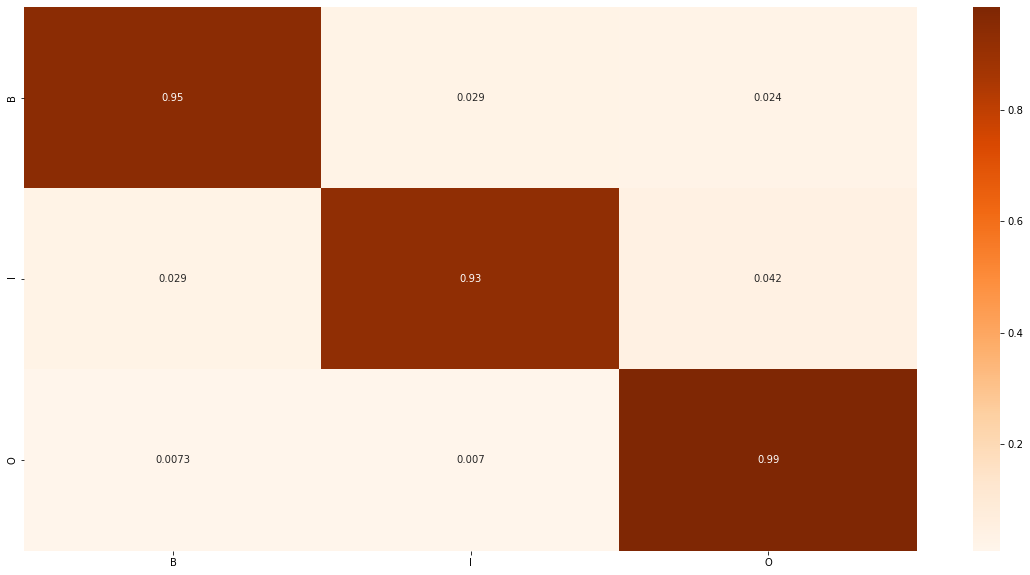

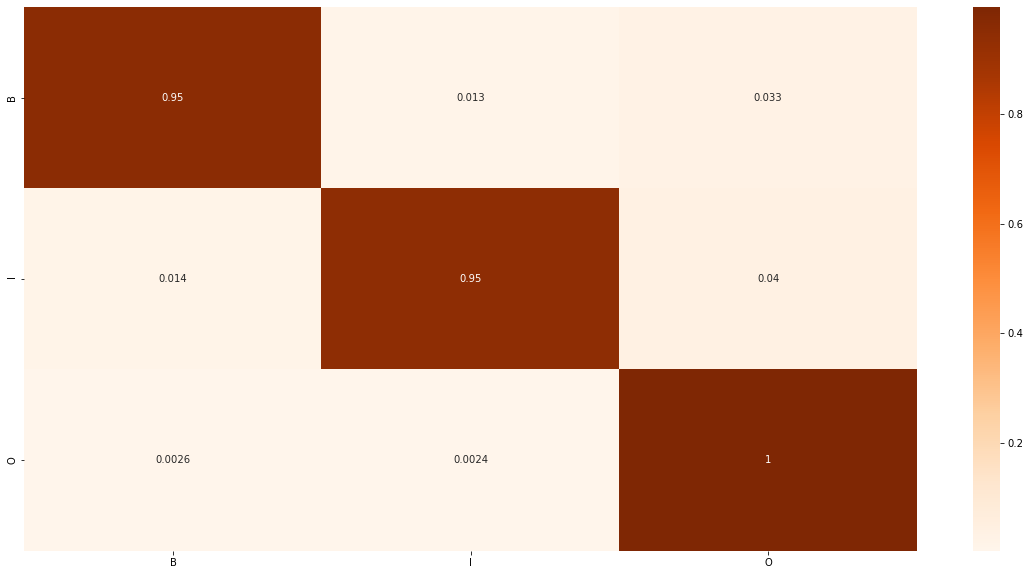

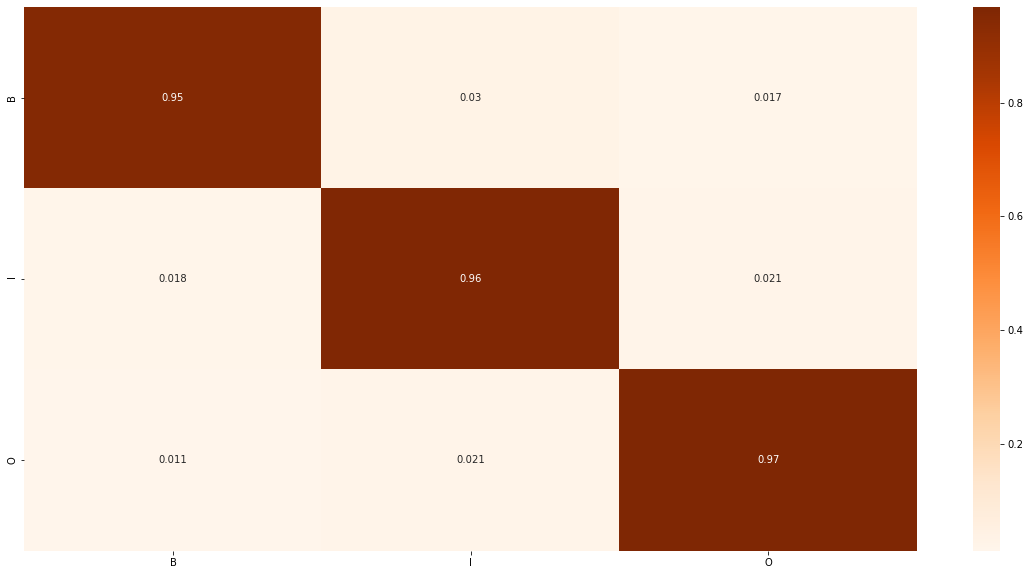

In [6]:
if (just_identify):
    dst_folder = "folds_CoNLL_identification/"
else:
    dst_folder = "folds_CoNLL_classification/"
    
for fold in range(n_folds):
    with open(dst_folder + "prediction_fold_{}.txt".format(fold), "r", encoding="utf-8") as fileReader:
        # list only the words that are between ' '
        prediction = re.findall("'([^']*)'", fileReader.read())

    with open(dst_folder + "CoNLL_test_fold_{}_v2.txt".format(fold), "r", encoding="utf-8") as fileReader:
        ground_truth = fileReader.read().split()
        del ground_truth[::2]
        
    if (just_identify):
        classes = ["B", "I", "O"]
    else:
        classes = [
            "O",
            "B-tempo",
            "I-tempo",
            "B-local",
            "I-local",
            "B-valor",
            "I-valor",
            "B-organizacao",
            "I-organizacao",
            "B-obra",
            "I-obra",
            "B-individuo",
            "I-individuo",
            "B-acontecimento",
            "I-acontecimento",
            "B-abstraccao",
            "I-abstraccao",
            "B-outro",
            "I-outro"
        ]
    
    precision_micro = precision_score(ground_truth, prediction, average='micro')
    precision_macro = precision_score(ground_truth, prediction, average='macro')
    recall_micro = recall_score(ground_truth, prediction, average="micro")
    recall_macro = recall_score(ground_truth, prediction, average="macro")
    f1_micro = f1_score(ground_truth, prediction, average='micro')
    f1_macro = f1_score(ground_truth, prediction, average='macro')
    
    print("----- FOLD {} -----".format(fold))
    print(len(prediction))
    print(len(ground_truth))
    print("precision_micro = {}".format(precision_micro))
    print("precision_macro = {}".format(precision_macro))
    print("recall_micro = {}".format(recall_micro))
    print("recall_macro = {}".format(recall_macro))
    print("f1_micro = {}".format(f1_micro))
    print("f1_macro = {}".format(f1_macro))
    print("\n")
      
    # generate the graphs of each confusion matrix
    # all values on the same line is the ground truth (from the CoNLL_test_fold file)
    # all values in the same column is the prediction (from the prediction_fold file)
    matriz = confusion_matrix(ground_truth, prediction, labels=classes, normalize="true")
    if should_plot_matrices:
        matriz_df = pd.DataFrame(matriz, index=classes, columns=classes)
        plt.figure(figsize=(20, 10))
        seaborn.heatmap(matriz_df, cmap="Oranges", annot=True)